# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
import music21

from src.fastai_data import *
from src.encode_data import *
from src.serve import *
from src.msklm import *

In [4]:
config = mlm_config(vocab);

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
data_save_name = 'multi_data_idxenc.pkl'

## MSKLM

In [6]:
data = load_data(numpy_path, data_save_name, bs=1)
learn = mlm_model_learner(data, config.copy(), loss_func=MultiLoss())

## Load existing

In [7]:
saved_models = get_files(numpy_path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('data/numpy/combined_tracks/models/MusicTransformer.pth'),
 PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')]

In [16]:
load_path = saved_models[1];
learn.load(load_path.stem);
load_path

PosixPath('data/numpy/combined_tracks/models/MultitaskTransformer.pth')

### Predictions - Get midi file

In [17]:
data_dir = 'data/midi/examples/'
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:5]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid'),
 PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')]

In [18]:
idx = 2
file = midi_files[idx]; file

PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid')

In [19]:
# Encode file 
x = midi2idxenc(file)
x_pos = neg_position_enc(x)

# Convert to tensor
x = torch.tensor(x)
x_pos = torch.tensor(x_pos)
if torch.cuda.is_available(): 
    x = x.cuda()
    x_pos = x_pos.cuda()

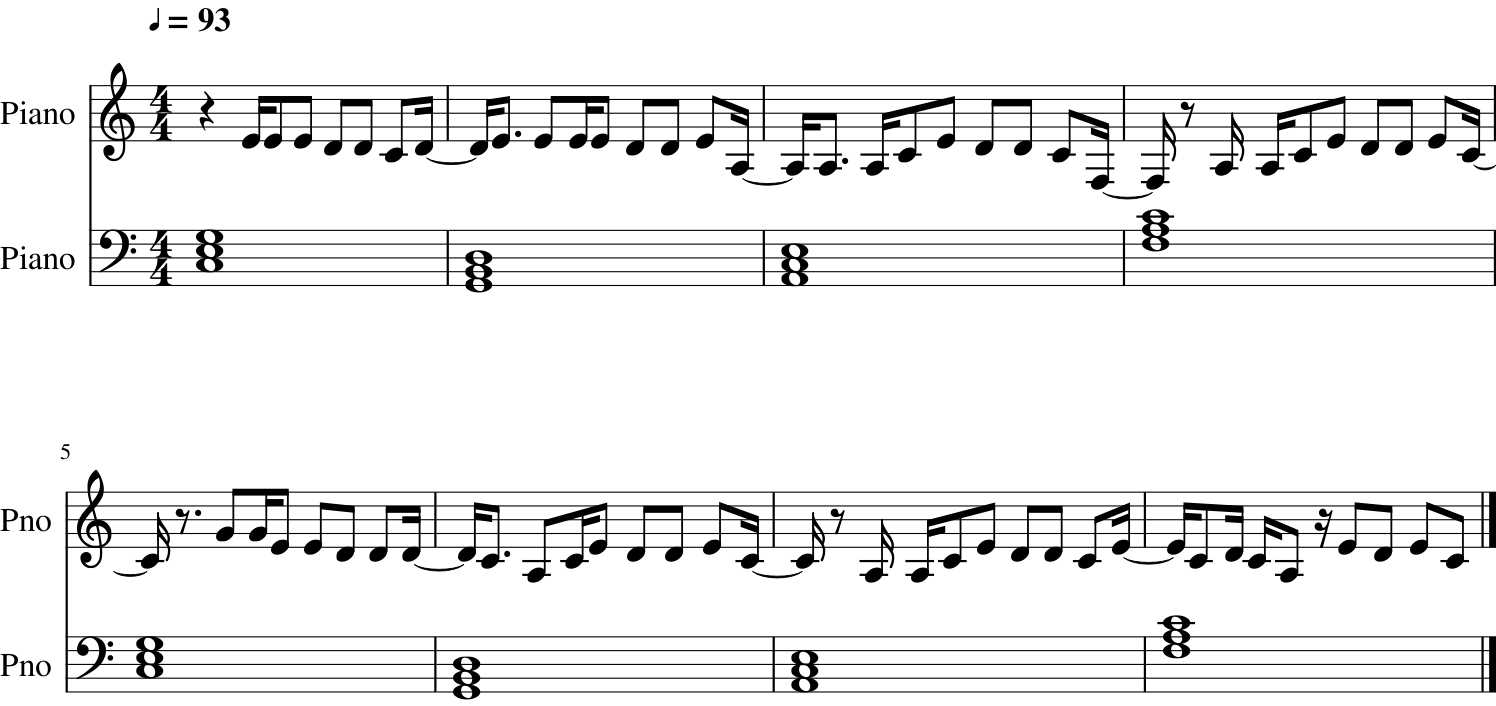

In [20]:
original_stream = file2stream(file)
original_stream.show()

In [21]:
original_stream.show('midi')

## Predict Mask

#### Regenerate durations

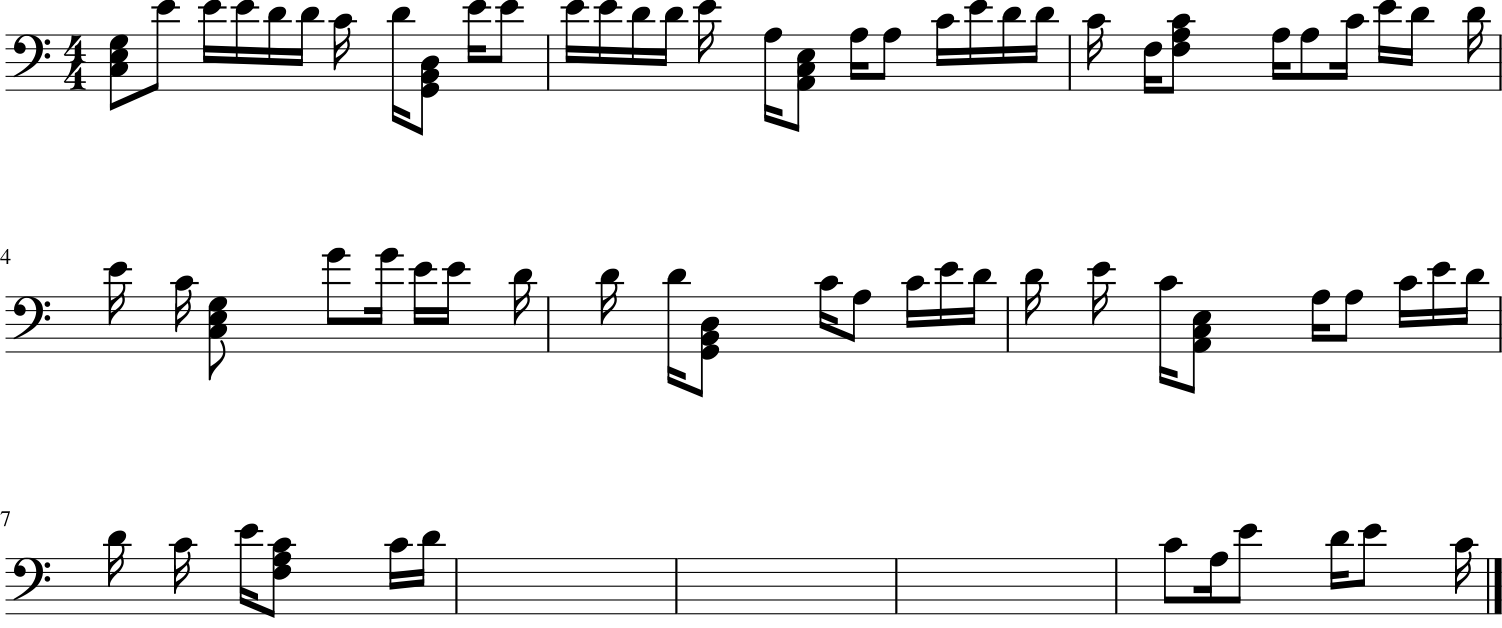

In [24]:
# duration mask
x_dur = mask_input(x, mask_range=vocab.dur_range)

pred = learn.predict_mask(x_dur, x_pos, temperatures=(0.8,0.8), top_k=40, top_p=0.6)
# pred = predict_mask(learn, x_dur, x_pos, temperatures=(0.8,0.8), top_k=40, top_p=0.6)

stream_dur = idxenc2stream(pred)
stream_dur.show()

In [25]:
stream_dur.show('midi')

#### Regenerate Notes

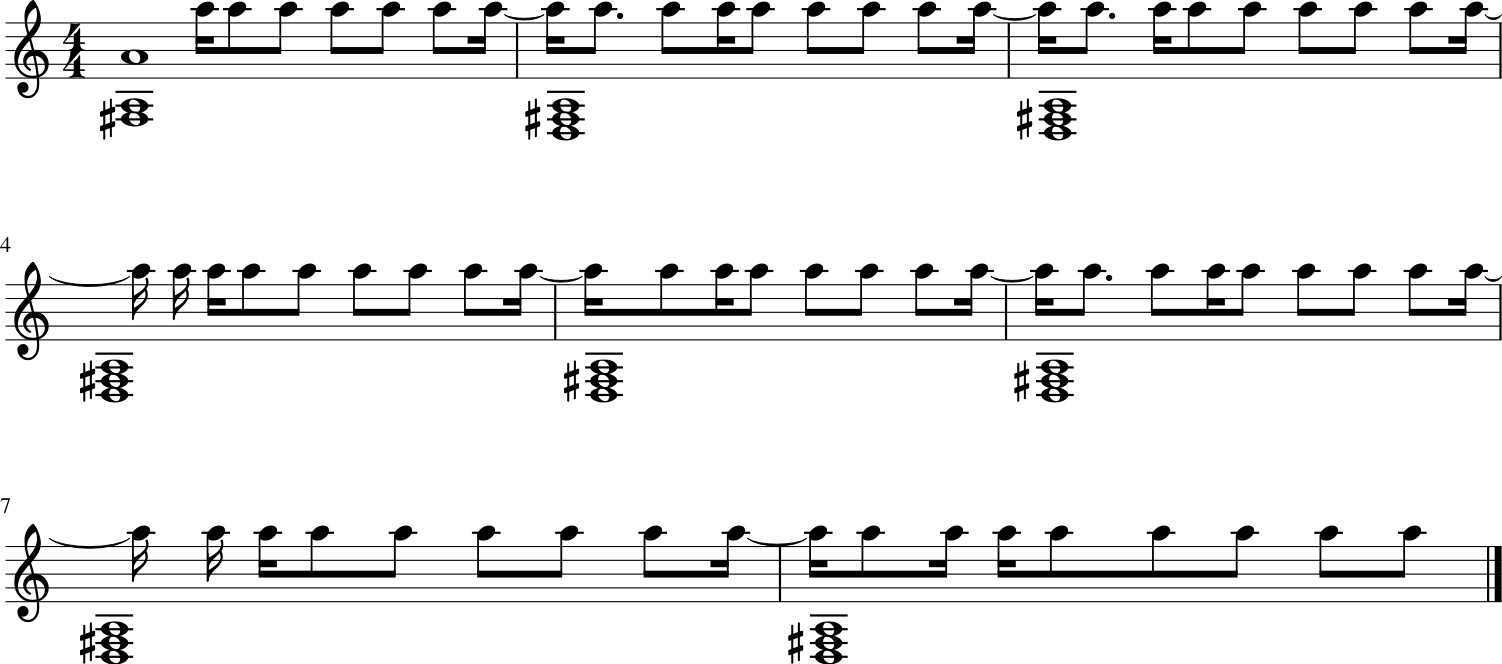

In [26]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
x_note = mask_input(x, mask_range=vocab.note_range)
pred_note = learn.predict_mask(x_note)

stream_note = idxenc2stream(pred_note)
stream_note.show()

In [27]:
vocab.textify(pred_note)

'xxbos xxpad n69 d16 n57 d16 n54 d16 xxsep d4 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d1 n81 d3 xxsep d3 n81 d2 xxsep d2 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d1 n81 d3 xxsep d3 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d3 n81 d1 xxsep d1 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d4 n81 d2 xxsep d2 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d1 n81 d3 xxsep d3 n81 d2 xxsep d2 n81 d1 xxsep d1 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d2 n81 d2 xxsep d1 n57 d16 n54 d16 n50 d16 xxsep d3 n81 d1 xxsep d1 n81 

In [28]:
stream_note.show('midi')

In [29]:
out = mask_predict_from_midi(learn, file, predict_notes=True)

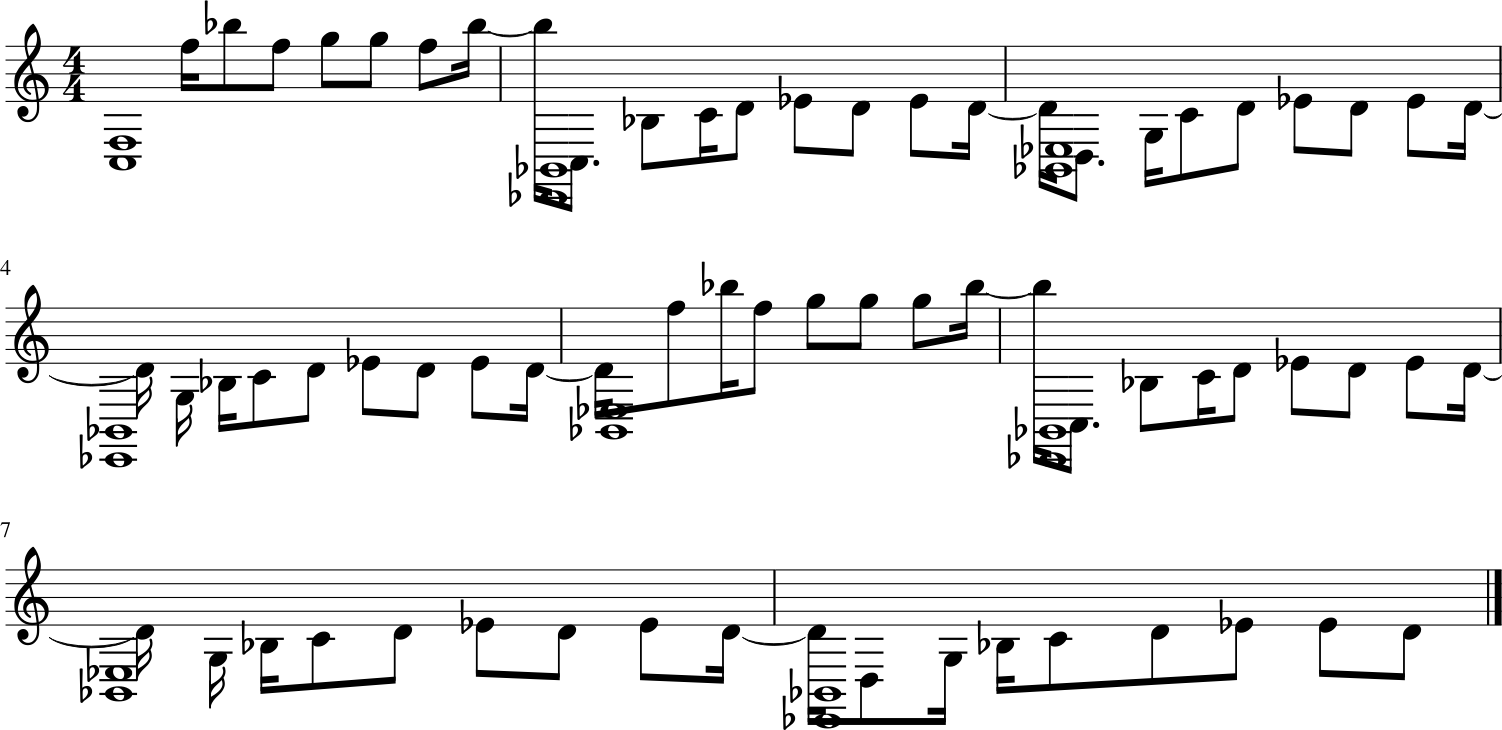

In [30]:
idxenc2stream(out).show()

## Prediction next word

In [31]:
seed_len = 4 # 4 beats = 1 bar
seed = seed_tfm(x, seed_len)

In [32]:
out = learn.predict_nw(seed, n_words=200)

Predicted BOS token. Returning prediction...


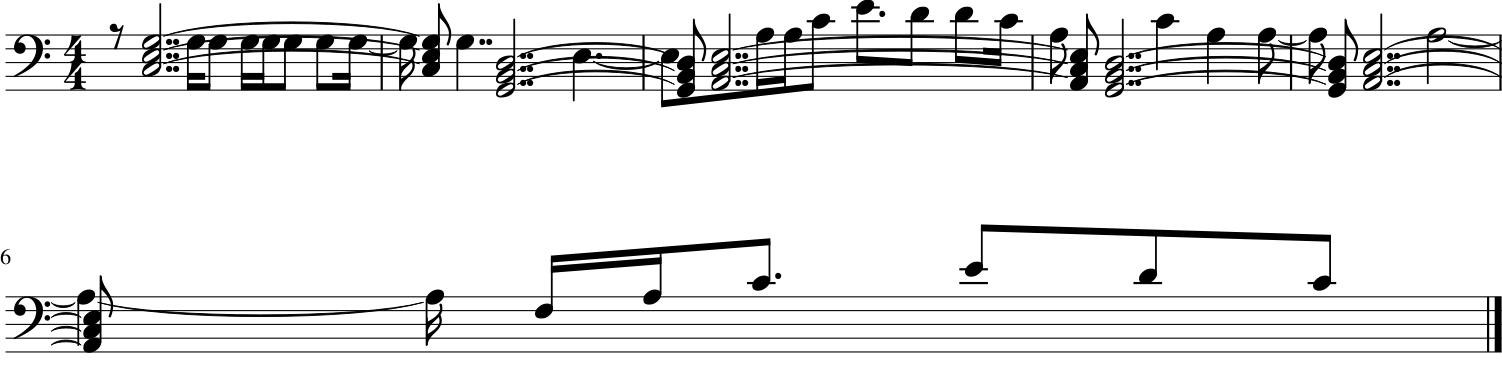

In [33]:
stream = idxenc2stream(out)
stream.show()

In [34]:
stream.show('midi')

Convenience function

In [36]:
out = nw_predict_from_midi(learn, file, seed_len=4, top_k=30, top_p=0.5)

Predicted BOS token. Returning prediction...


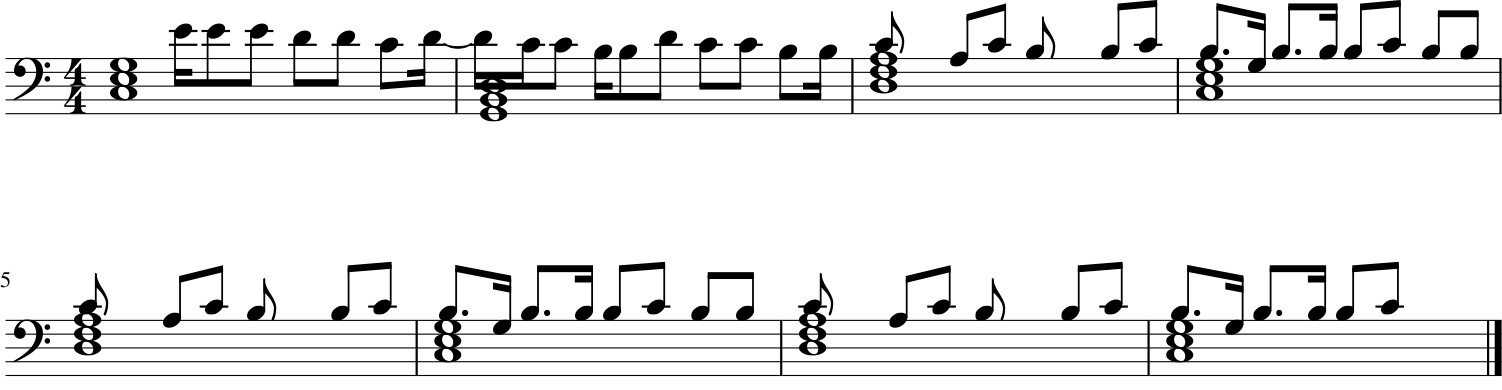

In [37]:
stream = idxenc2stream(out)
stream.show()

In [38]:
stream.show('midi')

## Predict Seq2Seq

In [39]:
melody, chords = midi_extract_melody_chords(file)

## Predict melody

In [40]:
melody_cut = seed_tfm(melody, seed_len=3)

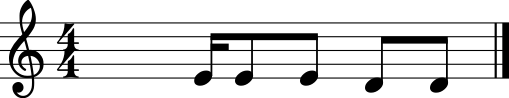

In [41]:
idxenc2stream(melody_cut).show()

In [42]:
xb_msk = torch.tensor(chords).cuda()
xb_lm = torch.tensor(melody_cut).cuda()

In [43]:
xb_msk.shape, xb_lm.shape

(torch.Size([65]), torch.Size([25]))

In [44]:
out = learn.predict_s2s(xb_msk, xb_lm)

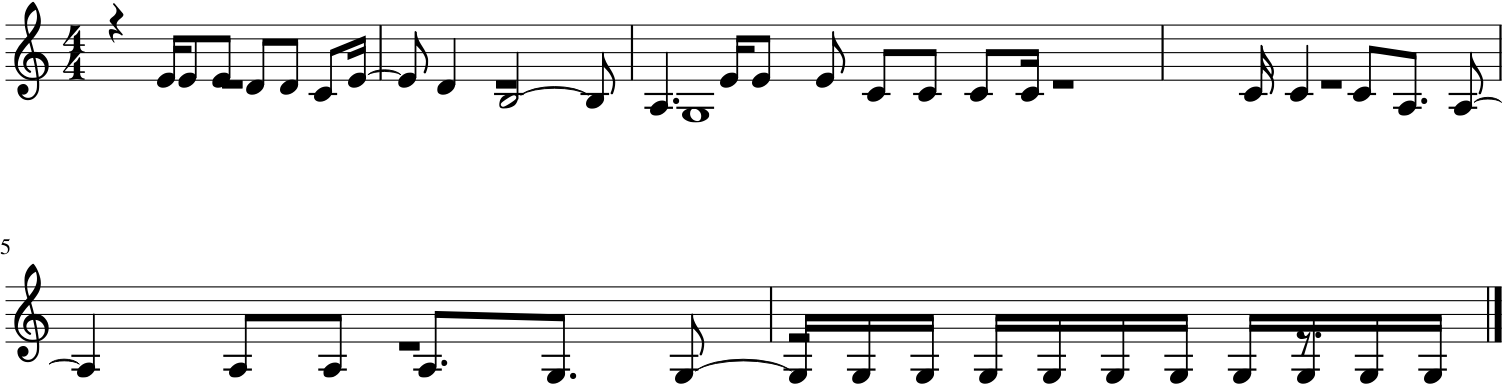

In [45]:
idxenc2stream(out).show()

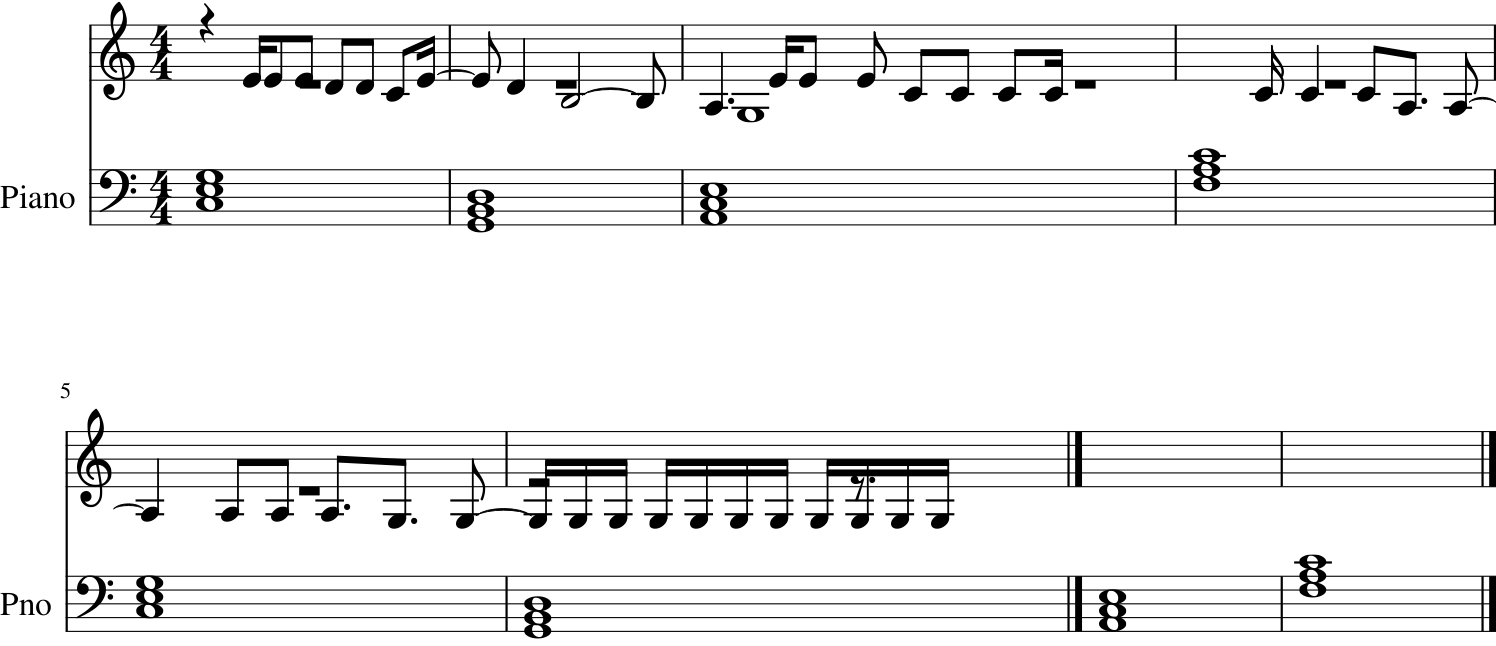

In [46]:
chordarr_comb = s2s_combine2chordarr(out, chords)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [47]:
comb_stream.show('midi')

## Predict chords

In [48]:
chord_cut = seed_tfm(chords, seed_len=3)

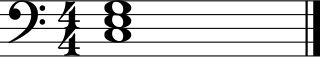

In [49]:
idxenc2stream(chord_cut).show()

In [50]:
xb_msk = torch.tensor(melody).cuda()
xb_lm = torch.tensor(chord_cut).cuda()

In [51]:
xb_msk.shape, xb_lm.shape

(torch.Size([251]), torch.Size([11]))

In [52]:
out = learn.predict_s2s(xb_msk, xb_lm)

Predicted past counter-part length. Returning early


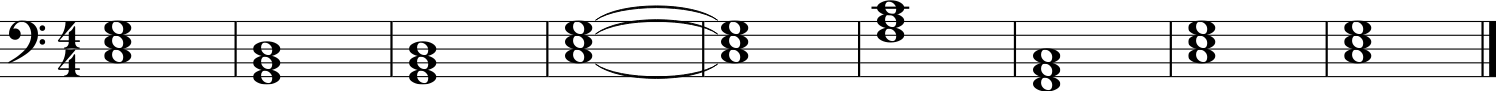

In [53]:
idxenc2stream(out).show()

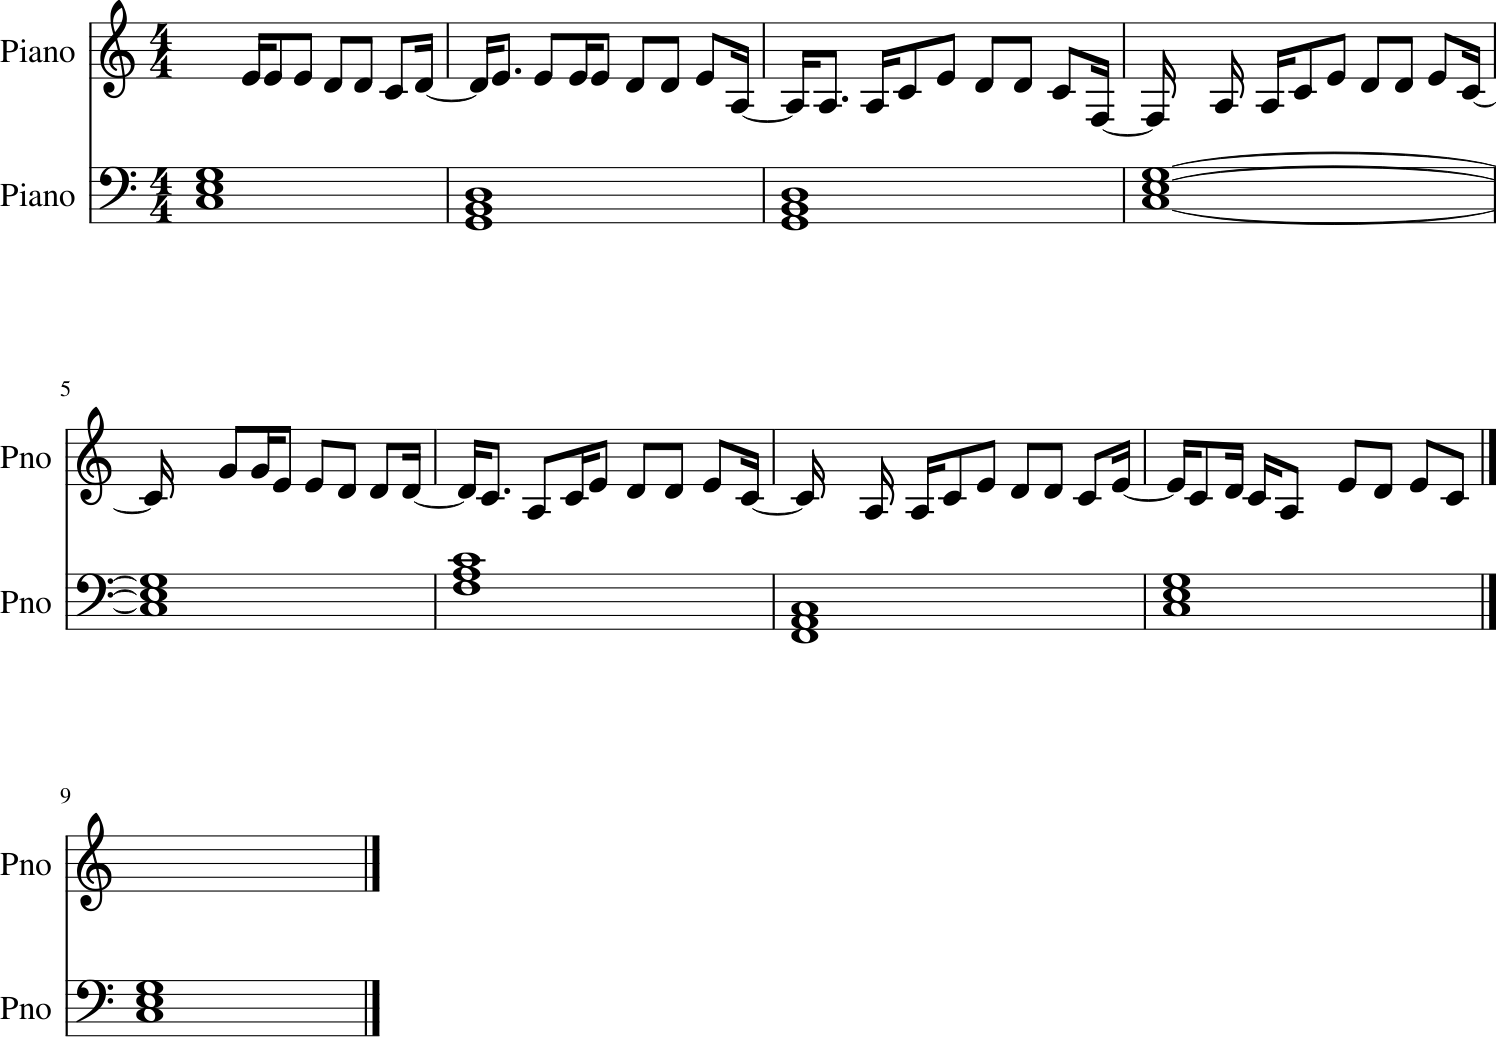

In [54]:
chordarr_comb = s2s_combine2chordarr(melody, out)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [55]:
comb_stream.show('midi')

Convenience Function

In [56]:
out = s2s_predict_from_midi(learn, file, seed_len=10)

Predicted past counter-part length. Returning early


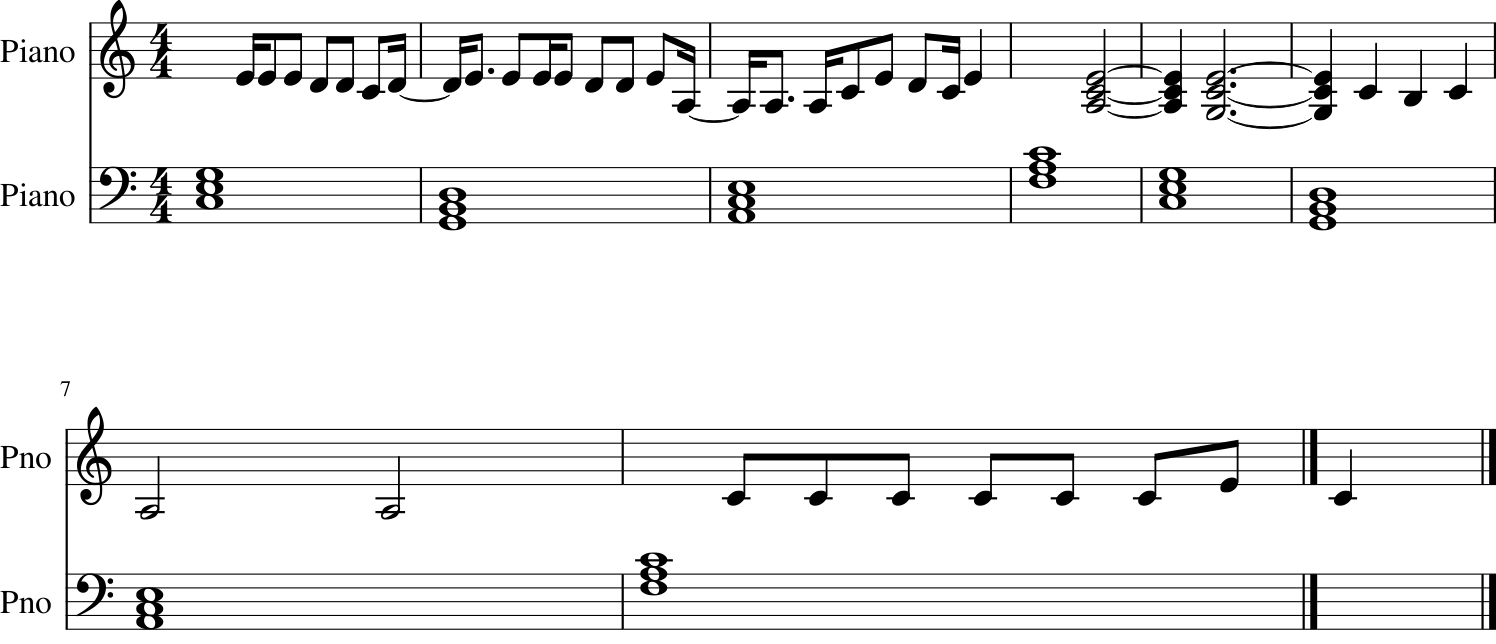

In [57]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()